### Example 2: Nonlinear convection in 2D

Following the initial convection tutorial with a single state variable $u$, we will now look at non-linear convection (step 6 in the original). This brings one new crucial challenge: computing a pair of coupled equations and thus updating two time-dependent variables $u$ and $v$.

The full set of coupled equations is now

\begin{aligned}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = 0 \\
\\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = 0\\
\end{aligned}

and rearranging the discretised version gives us an expression for the update of both variables

\begin{aligned}
u_{i,j}^{n+1} &= u_{i,j}^n - u_{i,j} \frac{\Delta t}{\Delta x} (u_{i,j}^n-u_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (u_{i,j}^n-u_{i,j-1}^n) \\
\\
v_{i,j}^{n+1} &= v_{i,j}^n - u_{i,j} \frac{\Delta t}{\Delta x} (v_{i,j}^n-v_{i-1,j}^n) - v_{i,j}^n \frac{\Delta t}{\Delta y} (v_{i,j}^n-v_{i,j-1}^n)
\end{aligned}

So, for starters we will re-create the original example run in pure NumPy array notation, before demonstrating 
the Devito version. Let's start again with some utilities and parameters:

In [1]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 101
ny = 101
nt = 80
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .2
dt = sigma * dx

Let's re-create the initial setup with a 2D "hat function", but this time for two state variables.

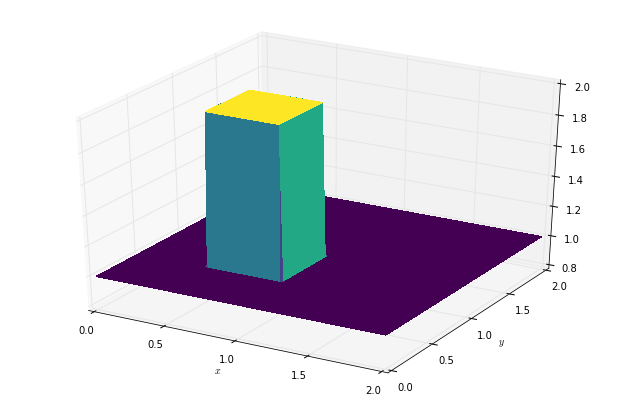

In [2]:
# Allocate fields and assign initial conditions
u = np.empty((nx, ny))
v = np.empty((nx, ny))

init_hat(field=u, dx=dx, dy=dy, value=2.)
init_hat(field=v, dx=dx, dy=dy, value=2.)

plot_field(u)

Now we can create the two stencil expression for our two coupled equations according to the discretised equation above. We again use some simple Dirichlet boundary conditions to keep the values on all sides constant.

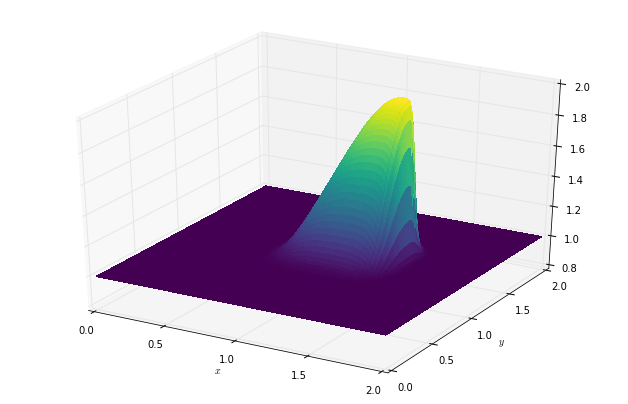

In [3]:
for n in range(nt + 1): ##loop across number of time steps
    un = u.copy()
    vn = v.copy()
    u[1:, 1:] = (un[1:, 1:] - 
                 (un[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -
                  vn[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[:-1, 1:]))
    v[1:, 1:] = (vn[1:, 1:] -
                 (un[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[1:, :-1])) -
                 vn[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[:-1, 1:]))
    
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1
    
plot_field(u)

Excellent, we gain get a wave that resembles the one from the oiginal examples.

Now we can set up our coupled problem in Devito. Let's start by creating two initial state variables $u$ and $v$, as before, and intialising them with our "hat function.

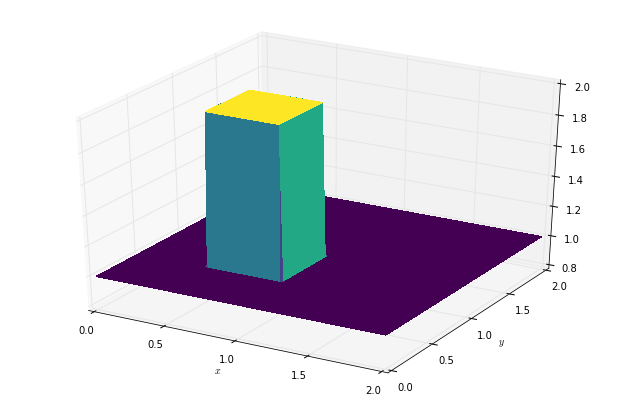

In [4]:
from devito import TimeData

# First we need two time-dependent data fields, both initialised with the hat function
u = TimeData(name='u', shape=(nx, ny))
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)

v = TimeData(name='u', shape=(nx, ny))
init_hat(field=v.data[0], dx=dx, dy=dy, value=2.)

plot_field(u.data[0])

Using the tow `TimeData` objects we can again derive our dicretized equation, rearrange for the forward stencil point in time and define our variable update expression - only we have to do everything twice now! We again use foward differences for time via `u.dt` and backward differnces in space via `u.dxl` and `u.dyl` to match the original tutorial.

In [5]:
from sympy import Eq, solve
from devito import Operator

eq_u = Eq(u.dt + u*u.dxl + v*u.dyl)
eq_v = Eq(v.dt + u*v.dxl + v*v.dyl)

# We can use the same SymPy trick to generate two
# stencil expressions, one for each field update.
stencil_u = solve(eq_u, u.forward)[0]
stencil_v = solve(eq_v, v.forward)[0]
update_u = Eq(u.forward, stencil_u)
update_v = Eq(v.forward, stencil_v)

print("U update:\n%s\n" % update_u)
print("V update:\n%s\n" % update_v)

U update:
Eq(u(t + s, x, y), (h*u(t, x, y) - s*u(t, x, y)**2 - s*u(t, x, y)*u(t, x, y) + s*u(t, x, y)*u(t, x - h, y) + s*u(t, x, y)*u(t, x, y - h))/h)

V update:
Eq(u(t + s, x, y), (h*u(t, x, y) - s*u(t, x, y)*u(t, x, y) + s*u(t, x, y)*u(t, x - h, y) - s*u(t, x, y)**2 + s*u(t, x, y)*u(t, x, y - h))/h)



We then set Dirichlet boundary conditions at all sides of the domain to $1$.

In [6]:
from devito import t, x, y
bc_u = [Eq(u.indexed[t+1, 0, y], 1.)]  # left
bc_u += [Eq(u.indexed[t+1, nx-1, y], 1.)]  # right
bc_u += [Eq(u.indexed[t+1, x, ny-1], 1.)]  # top
bc_u += [Eq(u.indexed[t+1, x, 0], 1.)]  # bottom
bc_v = [Eq(v.indexed[t+1, 0, y], 1.)]  # left
bc_v += [Eq(v.indexed[t+1, nx-1, y], 1.)]  # right
bc_v += [Eq(v.indexed[t+1, x, ny-1], 1.)]  # top
bc_v += [Eq(v.indexed[t+1, x, 0], 1.)]  # bottom

And finally we can put it all together to buuild an operator and solve our coupled problem.

DSE: extract_time_invariants [flops: 9, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 9, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 9, elapsed: 0.00] >>
     factorize [flops: 8, elapsed: 0.01] >>
     finalize [flops: 8, elapsed: 0.00]
     [Total elapsed: 0.02 s]
DSE: extract_time_invariants [flops: 0, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 0, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 0, elapsed: 0.00] >>
     factorize [flops: 0, elapsed: 0.00] >>
     finalize [flops: 0, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DSE: extract_time_invariants [flops: 0, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 0, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 0, elapsed: 0.00] >>
     factorize [flops: 0, elapsed: 0.00] >>
     finalize [flops: 0, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: analyze [elapsed: 0.01] >>
     avoid_denormals [elapsed

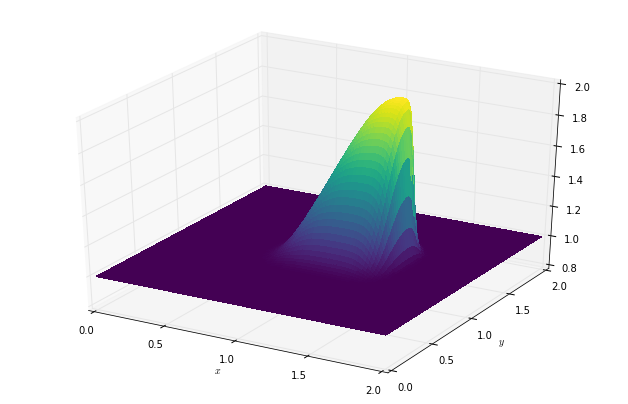

In [7]:
from sympy.abc import h, s
from devito import Operator

# Reset our data field and ICs
init_hat(field=u.data[0], dx=dx, dy=dy, value=2.)
init_hat(field=v.data[0], dx=dx, dy=dy, value=2.)

op = Operator([update_u, update_v] + bc_u + bc_v,
              subs={h: dx, s: dt})
op(time=nt+1)

plot_field(u.data[0, :, :])